# BIOPuffs QUARTOD (IOOS QC) Test

In [1]:
from erddapy import ERDDAP
import pandas as pd
import datetime
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

server_url = 'http://heron.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)
dfname = pd.read_csv(e.get_search_url(response='csv', search_for=f'POPS AND GPS_'))

gpdf_all = {}
for dataset in sorted(dfname['Dataset ID'].values):
    print(dataset)

    d = ERDDAP(server=server_url,
               protocol='tabledap',
               response='csv',
              )

    d.dataset_id=dataset

    gpdf = d.to_pandas(
        index_col='time (UTC)',
        parse_dates=True,
        skiprows=(1,)  # units information can be dropped.
    )

    gpdf.sort_index(inplace=True)
    gpdf.columns = [x[1].split()[0] for x in enumerate(gpdf.columns)]

    if not 'GPS' in dataset:
        pass
    else:
        gpdf['LatDD'] = ((gpdf['Latitude']/100-np.floor(gpdf['Latitude']/100))*100 / 60) + gpdf['Latitude']/100
        gpdf['LonDD'] = -1*(((gpdf['Longitude']/100-np.floor(gpdf['Longitude']/100))*100 / 60) + gpdf['Longitude']/100)

    gpdf['timeseries_id'] = dataset.split('_')[0]

    gpdf_all.update({dataset:gpdf})

POPS0001_GPS_0001
POPS0002_GPS_0002
POPS0004_GPS_0004
POPS0005_GPS_0005
POPS0006_GPS_0006
POPS0007_GPS_0007
POPS0008_GPS_0008
POPS0009_GPS_0009
POPS0010_GPS_0010


In [2]:
dfname = pd.read_csv(e.get_search_url(response='csv', search_for=f'POPS_'))

df_all = {}
for dataset in sorted(dfname['Dataset ID'].values):
    print(dataset)

    d = ERDDAP(server=server_url,
               protocol='tabledap',
               response='csv',
              )

    d.dataset_id=dataset

    pdf = d.to_pandas(
        index_col='time (UTC)',
        parse_dates=True,
        skiprows=(1,)  # units information can be dropped.
    )

    pdf.sort_index(inplace=True)
    pdf.columns = [x[1].split()[0] for x in enumerate(pdf.columns)]

    if not 'GPS' in dataset:
        pdf['Pressure_Bar'] = pdf['Depth'].apply(lambda x: int(x, 16)/100 )
        pdf['Temp_DegC_0'] = pdf['TempProbe0'].apply(lambda x: int(x, 16)/1000 )
        pdf['Temp_DegC_1'] = pdf['TempProbe1'].apply(lambda x: int(x, 16)/1000 )
    else:
        pdf['LatDD'] = ((pdf['Latitude']/100-np.floor(pdf['Latitude']/100))*100 / 60) + pdf['Latitude']/100
        pdf['LonDD'] = -1*(((pdf['Longitude']/100-np.floor(pdf['Longitude']/100))*100 / 60) + pdf['Longitude']/100)
    
    pops_deploy = {
        '0001':[58.9931667,-175.00267,datetime.date(2021,5,13),131,datetime.date(2021,9,15)],
        '0002':[55.442,-163.74017,datetime.date(2021,5,7),83,datetime.date(2021,9,15)],
        '0004':[59.69,-176.705,datetime.date(2021,5,13),139,datetime.date(2021,9,15)],
        '0005':[56.4471667,-168.49617,datetime.date(2021,5,13),121,datetime.date(2021,9,15)], #startdate looks later than records? by 9 days
        '0006':[56.7043333,-171.2195,datetime.date(2021,5,14),'NaN',datetime.date(2021,9,15)],
        '0007':[61.0698333,-177.773,datetime.date(2021,5,12),141.5,datetime.date(2021,9,15)],
        '0008':[59.243995,-169.41832,datetime.date(2021,5,10),54.9,datetime.date(2021,9,15)],
        '0009':[60.7788333,-174.49733,datetime.date(2021,5,12),91,datetime.date(2021,9,15)],
        '0010':[55.2358333,-166.1298,datetime.date(2021,5,15),130,datetime.date(2021,9,15)]
    }
    
    if '0006' in dataset.split('_')[-1]:
        pdf['Pressure_Bar'] = np.nan
        
    pdf['latitude'] = pops_deploy[dataset.split('_')[-1]][0]
    pdf['longitude'] = pops_deploy[dataset.split('_')[-1]][1]
    pdf['timeseries_id'] = dataset.split('_')[0]
    pdf = pdf[pops_deploy[dataset.split('_')[-1]][2]:].copy()
    pdf.loc[:,'measurement_type'] = 'bottom'
    pdf.loc[pops_deploy[dataset.split('_')[-1]][4]:,'measurement_type'] = 'surface'
        
    df_all.update({dataset:pdf})

POPS0001_POPS_0001
POPS0002_POPS_0002
POPS0004_POPS_0004
POPS0005_POPS_0005
POPS0006_POPS_0006
POPS0007_POPS_0007
POPS0008_POPS_0008
POPS0009_POPS_0009
POPS0010_POPS_0010


In [3]:
# merge results of all input, alternatively we could qc each stream seperatly (bottom vs top)

df_all_merged=pd.DataFrame()
for dataset_id in df_all.keys():
    df_all_merged = df_all_merged.append(df_all[dataset_id])
df_all_merged

,Epoch_Time,Depth,TempProbe0,TempProbe1,Pressure_Bar,Temp_DegC_0,Temp_DegC_1,latitude,longitude,timeseries_id,measurement_type
time (UTC),,,,,,,,,,,
2021-05-13 00:10:00+00:00,609C6E58,32d6,06b2,06ba,130.14,1.714,1.722,58.993167,-175.00267,POPS0001,bottom
2021-05-13 01:10:00+00:00,609C7C68,32e5,071f,0728,130.29,1.823,1.832,58.993167,-175.00267,POPS0001,bottom
2021-05-13 02:10:00+00:00,609C8A78,32f7,0715,071e,130.47,1.813,1.822,58.993167,-175.00267,POPS0001,bottom
2021-05-13 03:10:00+00:00,609C9888,330b,0707,070f,130.67,1.799,1.807,58.993167,-175.00267,POPS0001,bottom
2021-05-13 04:10:00+00:00,609CA698,331e,0717,0721,130.86,1.815,1.825,58.993167,-175.00267,POPS0001,bottom
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08 19:10:00+00:00,61B10308,0014,0134,0146,0.20,0.308,0.326,55.235833,-166.12980,POPS0010,surface
2021-12-08 20:10:00+00:00,61B11118,0013,fe80,fe5c,0.19,65.152,65.116,55.235833,-166.12980,POPS0010,surface
2021-12-08 21:10:00+00:00,61B11F28,0015,0031,0062,0.21,0.049,0.098,55.235833,-166.12980,POPS0010,surface


In [4]:
# for tvar in ['Temp_DegC_0','Temp_DegC_1']:
#     results = qartod.gross_range_test(
#         inp=df_all_merged[tvar],
#         suspect_span=[-2, 15],
#         fail_span=[-2, 25]
#     )

#     df_all_merged[tvar+'_QC'] = results

In [5]:
df_all_merged

,Epoch_Time,Depth,TempProbe0,TempProbe1,Pressure_Bar,Temp_DegC_0,Temp_DegC_1,latitude,longitude,timeseries_id,measurement_type
time (UTC),,,,,,,,,,,
2021-05-13 00:10:00+00:00,609C6E58,32d6,06b2,06ba,130.14,1.714,1.722,58.993167,-175.00267,POPS0001,bottom
2021-05-13 01:10:00+00:00,609C7C68,32e5,071f,0728,130.29,1.823,1.832,58.993167,-175.00267,POPS0001,bottom
2021-05-13 02:10:00+00:00,609C8A78,32f7,0715,071e,130.47,1.813,1.822,58.993167,-175.00267,POPS0001,bottom
2021-05-13 03:10:00+00:00,609C9888,330b,0707,070f,130.67,1.799,1.807,58.993167,-175.00267,POPS0001,bottom
2021-05-13 04:10:00+00:00,609CA698,331e,0717,0721,130.86,1.815,1.825,58.993167,-175.00267,POPS0001,bottom
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08 19:10:00+00:00,61B10308,0014,0134,0146,0.20,0.308,0.326,55.235833,-166.12980,POPS0010,surface
2021-12-08 20:10:00+00:00,61B11118,0013,fe80,fe5c,0.19,65.152,65.116,55.235833,-166.12980,POPS0010,surface
2021-12-08 21:10:00+00:00,61B11F28,0015,0031,0062,0.21,0.049,0.098,55.235833,-166.12980,POPS0010,surface


In [6]:
df_all_merged.drop(columns=['Epoch_Time','Depth','TempProbe0','TempProbe1'],inplace=True)
df_all_merged.index = df_all_merged.index.tz_convert(None)

In [7]:
df_all_merged = df_all_merged.reset_index()
df_all_merged

,time (UTC),Pressure_Bar,Temp_DegC_0,Temp_DegC_1,latitude,longitude,timeseries_id,measurement_type
0,2021-05-13 00:10:00,130.14,1.714,1.722,58.993167,-175.00267,POPS0001,bottom
1,2021-05-13 01:10:00,130.29,1.823,1.832,58.993167,-175.00267,POPS0001,bottom
2,2021-05-13 02:10:00,130.47,1.813,1.822,58.993167,-175.00267,POPS0001,bottom
3,2021-05-13 03:10:00,130.67,1.799,1.807,58.993167,-175.00267,POPS0001,bottom
4,2021-05-13 04:10:00,130.86,1.815,1.825,58.993167,-175.00267,POPS0001,bottom
...,...,...,...,...,...,...,...,...
45931,2021-12-08 19:10:00,0.20,0.308,0.326,55.235833,-166.12980,POPS0010,surface
45932,2021-12-08 20:10:00,0.19,65.152,65.116,55.235833,-166.12980,POPS0010,surface
45933,2021-12-08 21:10:00,0.21,0.049,0.098,55.235833,-166.12980,POPS0010,surface
45934,2021-12-08 22:10:00,0.17,0.532,0.565,55.235833,-166.12980,POPS0010,surface


In [8]:
from ioos_qc import qartod
import pandas as pd
from ioos_qc.streams import PandasStream
from ioos_qc.stores import PandasStore
from ioos_qc.config import Config
from ioos_qc.results import collect_results


In [36]:
qc_config = {
    'Pressure_Bar': {
        'qartod': {
          "gross_range_test": {
            "fail_span": [-0.5,400],
            "suspect_span": [-0.1,300]
          },
          # "flat_line_test": { #not valid for bottom data
          #   "tolerance": 0.001,
          #   "suspect_threshold": 10800,
          #   "fail_threshold": 21600
          # },
          "rate_of_change_test": {
            "threshold": 0.2
          },
          "spike_test": {
            "suspect_threshold": 0.8,
            "fail_threshold": 3
          },
          "aggregate": {}
        }
    },
    'Temp_DegC_0': {
        'qartod': {
          "gross_range_test": {
            "fail_span": [-2,25],
            "suspect_span": [-2,14]
          },
          # "flat_line_test": { #not valid for bottom data
          #   "tolerance": 0.001,
          #   "suspect_threshold": 10800,
          #   "fail_threshold": 21600
          # },
          "rate_of_change_test": {
            "threshold": 0.1
          },
          "spike_test": {
            "suspect_threshold": 0.8,
            "fail_threshold": 3
          },
          "aggregate": {}
        }
    },
    'Temp_DegC_1': {
        'qartod': {
          "gross_range_test": {
            "fail_span": [-2,25],
            "suspect_span": [-2,14]
          },
          # "flat_line_test": { #not valid for bottom data
          #   "tolerance": 0.001,
          #   "suspect_threshold": 10800,
          #   "fail_threshold": 21600
          # },
          "rate_of_change_test": {
            "threshold": 0.2
          },
          "spike_test": {
            "suspect_threshold": 1.0,
            "fail_threshold": 4
          },
          "aggregate": {}
        }
    }
}
c = Config(qc_config)

In [37]:
# Setup the stream
ps = PandasStream(df_all_merged, time='time (UTC)', lat='latitude', lon='longitude', z='Pressure_Bar')

# Run the tests by passing in a Config object
results = ps.run(c)

store = PandasStore(results)

Could not run "qartod.aggregate: aggregate() missing 1 required positional argument: 'results'
Could not run "qartod.aggregate: aggregate() missing 1 required positional argument: 'results'
Could not run "qartod.aggregate: aggregate() missing 1 required positional argument: 'results'


In [38]:
# Compute any aggregations
store.compute_aggregate(name='rollup_qc')  # Appends to the results internally

# Write only the test results to the store
results_store = store.save(write_data=False, write_axes=False)

# Append columns from qc results back into the data - stick to simple case of aggregate only for now
results_store = pd.concat([df_all_merged, 
                           results_store], axis=1)

<AxesSubplot:>

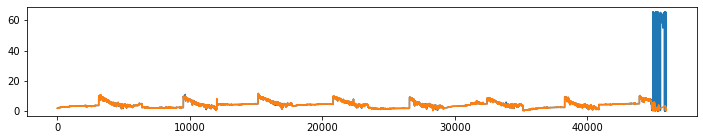

In [39]:
results_store.Temp_DegC_1.plot()
results_store[(results_store['qartod_rollup_qc']==1) | (results_store['qartod_rollup_qc']==2)].Temp_DegC_1.plot(figsize=(12,2))

Pressure_Bar_qartod_gross_range_test
Pressure_Bar_qartod_rate_of_change_test
Pressure_Bar_qartod_spike_test
Temp_DegC_0_qartod_gross_range_test
Temp_DegC_0_qartod_rate_of_change_test
Temp_DegC_0_qartod_spike_test
Temp_DegC_1_qartod_gross_range_test
Temp_DegC_1_qartod_rate_of_change_test
Temp_DegC_1_qartod_spike_test
qartod_rollup_qc


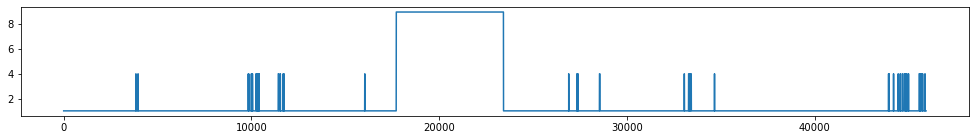

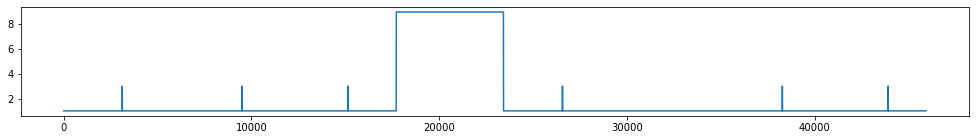

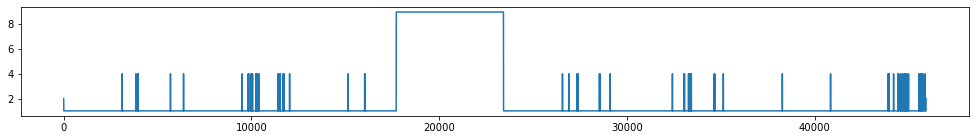

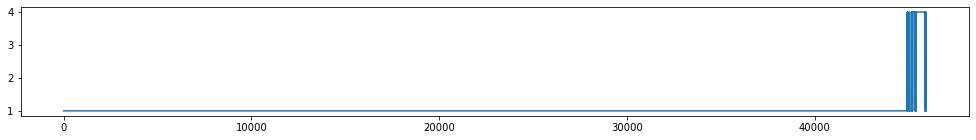

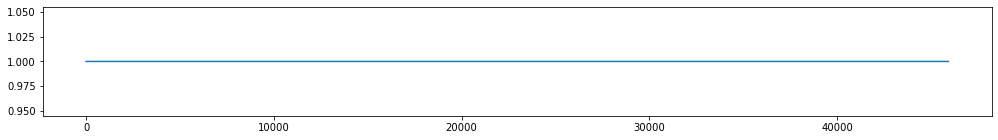

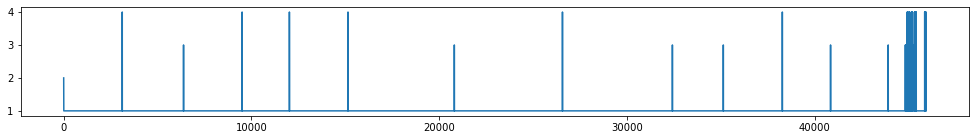

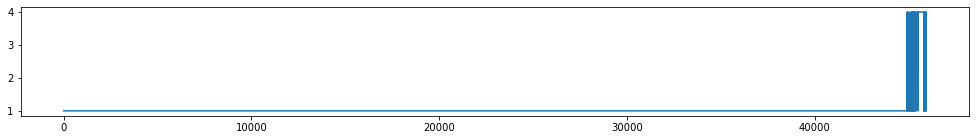

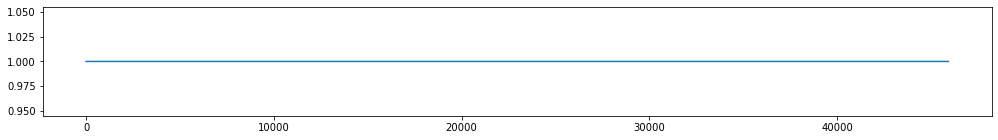

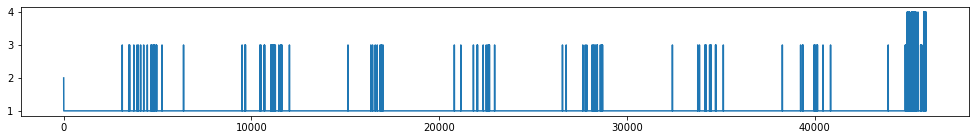

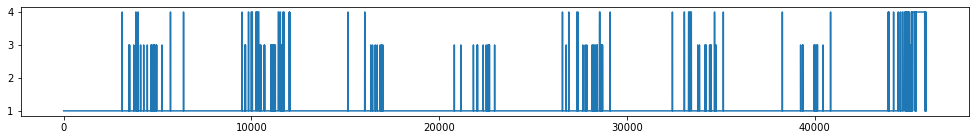

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

for keys in results_store.keys():
    if 'qartod' in keys:
        print(keys)
        fig, ax = plt.subplots(figsize=(17, 2))

        results_store[keys].plot(ax=ax)

In [29]:
## keep 1,2 for each parameter and address parameters/test independently

for keys in results_store.keys():
    if 'qartod' in keys:
        # print(keys)
        results_store.loc[(results_store[keys] != 1) & (results_store[keys] != 2),keys.split('_qartod')[0]] = np.nan
results_store = results_store.loc[:, ~results_store.columns.str.contains('qartod')]